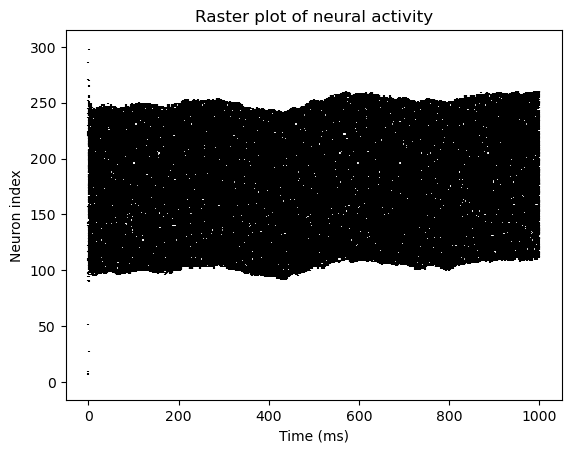

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Network parameters
N = 300  # number of neurons
J = 500  # interaction strength in picoCoulomb (pC)[^1^][1]
tau = 10  # time constant in ms
dt = 0.1  # time step in ms
T = 1000  # total simulation time in ms
time_steps = int(T / dt)
positions = np.linspace(0, 2*np.pi, N, endpoint=False)  # positions of neurons

# Initialize potentials
np.random.seed(0)  # for reproducibility
potentials = np.random.uniform(0, 1, N)

# Initialize spike trains
spike_trains = np.zeros((N, time_steps))

# Simulation
for t in range(1, time_steps):
    # Compute collective variables
    mcos = np.sum(np.cos(positions) * spike_trains[:, t-1]) / N
    msin = np.sum(np.sin(positions) * spike_trains[:, t-1]) / N
    
    # Update potentials and generate spikes
    for i in range(N):
        input_current = J * (np.cos(positions[i]) * mcos + np.sin(positions[i]) * msin)
        potentials[i] += dt/tau * (-potentials[i] + input_current)
        
        # Generate spike with Poisson process
        firing_rate = 1 / (1 + np.exp(-2 * (potentials[i] - 0.5)))
        spike_prob = firing_rate * dt
        if np.random.rand() < spike_prob:
            spike_trains[i, t] = 1/dt

# Raster plot of activity[^3^][3]
plt.eventplot([np.where(spike_trains[i, :])[0]*dt for i in range(N)], color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of neural activity')
plt.show()


In [38]:
import numpy as np

def decode_bump_location(spike_trains, positions, bin_size=10):
    """
    Decodes the location of the bump from the binned activity using the population vector.
    
    Parameters:
    spike_trains (2D numpy array): The spike trains of the neurons.
    positions (1D numpy array): The positions of each neuron.
    bin_size (int): The size of the bin in ms for determining the activity.
    
    Returns:
    bump_locations (1D numpy array): The decoded locations of the bump over time.
    """
    # Number of neurons and time steps
    N, T = spike_trains.shape
    
    # Binning the spike trains
    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, T, bin_size), axis=1)
    
    # Decoding the bump location
    bump_locations = []
    for t in range(binned_spike_trains.shape[1]):
        # Weighted sum of cos and sin of positions
        weighted_cos = np.sum(np.cos(positions) * binned_spike_trains[:, t])
        weighted_sin = np.sum(np.sin(positions) * binned_spike_trains[:, t])
        
        # Calculating the angle of the bump
        theta_bump = np.arctan2(weighted_sin, weighted_cos)
        bump_locations.append(theta_bump)
    
    return np.array(bump_locations)

# Example usage:
# Assuming `spike_trains` is a 2D numpy array with shape (N, T)
# and `positions` is a 1D numpy array with the positions of the neurons
theta_bump_over_time = decode_bump_location(spike_trains, positions)


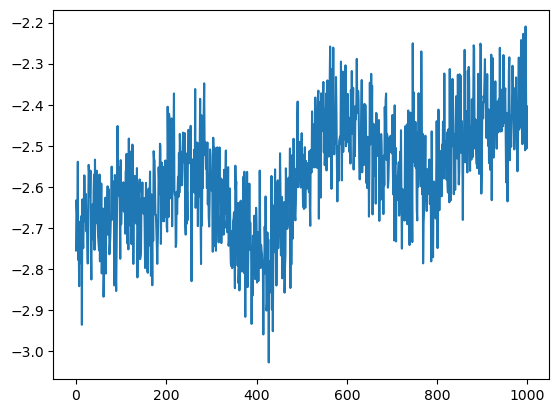

In [39]:
plt.plot(np.arange(T), theta_bump_over_time)

The location of the bump can drift due to the inherent stochasticity in the firing of Poisson neurons. Since the spikes are generated according to a Poisson process, there is randomness in the timing of each neuron's firing. This randomness can cause fluctuations in the collective activity, leading to the drift of the bump's location over time.

To improve the stability of the bump and reduce drift, you can consider modifying the parameters of the model in the following ways:

- **Increase the Number of Neurons (N):** A larger number of neurons can average out the randomness and reduce fluctuations, leading to a more stable bump. With more neurons, the network can represent the bump with higher resolution, and the effects of random spikes are less pronounced on the overall activity pattern.

- **Adjust the Integration Timescales (τ, ∆t):**
    - **Time Constant (τ):** A larger time constant can smooth out the fluctuations in the neural activity, as it causes the neuron's potential to decay more slowly. This can help maintain a more stable bump, but it may also slow down the network's response to changes.
    - **Time Step (∆t):** A smaller time step can lead to more accurate numerical integration of the differential equations governing the neurons' dynamics. This can help in capturing the nuances of the neural activity more precisely, potentially reducing drift.

- **Tuning Other Parameters:**
    - **Interaction Strength (J):** Adjusting the interaction strength between neurons can affect the stability of the bump. A carefully chosen value of J can help maintain a balance between the neurons' individual randomness and the collective behavior that forms the bump.
    - **Transfer Function Parameters (α, β):** The shape of the transfer function influences the neurons' responsiveness to input. Fine-tuning these parameters can affect the sharpness and stability of the bump.

Experimenting with these parameters within the context of your specific model and goals can help you find the optimal configuration for minimizing bump drift while maintaining the desired network dynamics. Remember that each change can have trade-offs, and finding the right balance is key to a successful simulation.

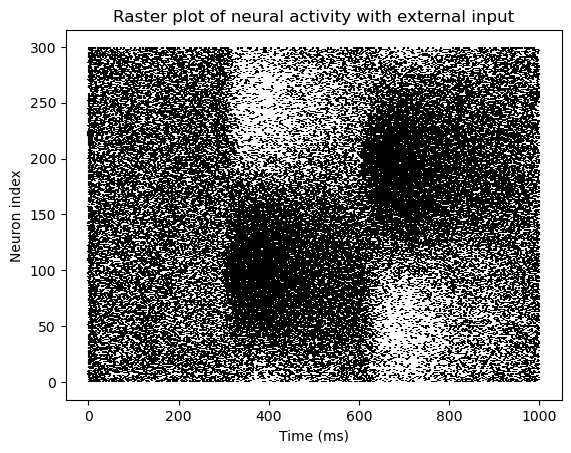

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Network parameters
N = 300  # number of neurons
J = 5  # interaction strength in picoCoulomb (pC)
tau = 10  # time constant in ms
dt = 0.1  # time step in ms
T = 1000  # total simulation time in ms
time_steps = int(T / dt)
positions = np.linspace(0, 2*np.pi, N, endpoint=False)  # positions of neurons

# External current parameters
sigma = np.pi / 8
mu1 = 2 * np.pi / 3
mu2 = 4 * np.pi / 3

# Initialize potentials
np.random.seed(0)  # for reproducibility
potentials = np.random.uniform(0, 1, N)

# Initialize spike trains
spike_trains = np.zeros((N, time_steps))

# Simulation
for t in range(1, time_steps):
    # Define external current for the current time step
    if 300 <= t*dt < 400:
        I_ext = np.exp(-((positions - mu1)**2) / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    elif 600 <= t*dt < 700:
        I_ext = np.exp(-((positions - mu2)**2) / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    else:
        I_ext = np.zeros(N)
    
    # Compute collective variables
    mcos = np.sum(np.cos(positions) * spike_trains[:, t-1]) / N
    msin = np.sum(np.sin(positions) * spike_trains[:, t-1]) / N
    
    # Update potentials and generate spikes
    for i in range(N):
        input_current = J * (np.cos(positions[i]) * mcos + np.sin(positions[i]) * msin) + I_ext[i]
        potentials[i] += dt/tau * (-potentials[i] + input_current)
        
        # Generate spike with Poisson process
        firing_rate = 1 / (1 + np.exp(-2 * (potentials[i] - 0.5)))
        spike_prob = firing_rate * dt
        if np.random.rand() < spike_prob:
            spike_trains[i, t] = 1/dt

# Raster plot of activity
plt.eventplot([np.where(spike_trains[i, :])[0]*dt for i in range(N)], color='black', linelengths=0.5, linewidths=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of neural activity with external input')
plt.show()


To simulate the network with the external input and observe the effect on the bump, you can modify the Python code to include the step currents at the specified locations and times. The external current is defined as a Gaussian function centered at two different locations, \( \mu^{(1)} \) and \( \mu^{(2)} \), with a standard deviation \( \sigma \).


This code introduces the external current `I_ext` during the specified time intervals. The effect of this input on the bump can be observed in the raster plot. Typically, the external current will cause the bump to shift towards the location of the current. This happens because the neurons at the location of the current receive additional input, increasing their firing rate and attracting the bump.

The connectivity profile, which is based on the cosine of the difference in positions, supports this behavior. Neurons that are closer in position have stronger connections (higher cosine values), so when a group of neurons receives an external current, it can influence its neighbors more strongly than distant neurons. This localized increase in activity can pull the bump towards the current's location.

By running the simulation and observing the raster plot, you can see how the bump responds to the external currents at different times and locations. The bump's movement and stability can be explained by the interplay between the external input and the network's connectivity profile.

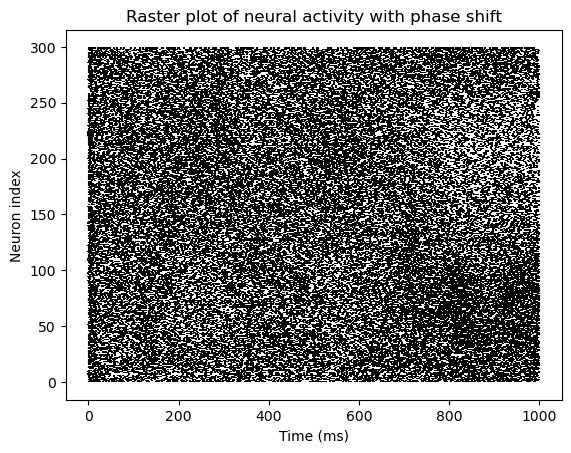

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Network parameters
N = 300  # number of neurons
J = 5  # interaction strength in picoCoulomb (pC)
tau = 10  # time constant in ms
dt = 0.1  # time step in ms
T = 1000  # total simulation time in ms
time_steps = int(T / dt)
positions = np.linspace(0, 2*np.pi, N, endpoint=False)  # positions of neurons
phi = 0.1  # small phase shift

# Initialize potentials
np.random.seed(0)  # for reproducibility
potentials = np.random.uniform(0, 1, N)

# Initialize spike trains
spike_trains = np.zeros((N, time_steps))

# Simulation
for t in range(1, time_steps):
    # Compute collective variables with phase shift
    mcos = np.sum(np.cos(positions - phi) * spike_trains[:, t-1]) / N
    msin = np.sum(np.sin(positions - phi) * spike_trains[:, t-1]) / N
    
    # Update potentials and generate spikes
    for i in range(N):
        input_current = J * (np.cos(positions[i] - phi) * mcos + np.sin(positions[i] - phi) * msin)
        potentials[i] += dt/tau * (-potentials[i] + input_current)
        
        # Generate spike with Poisson process
        firing_rate = 1 / (1 + np.exp(-2 * (potentials[i] - 0.5)))
        spike_prob = firing_rate * dt
        if np.random.rand() < spike_prob:
            spike_trains[i, t] = 1/dt

# Raster plot of activity
plt.eventplot([np.where(spike_trains[i, :])[0]*dt for i in range(N)], color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of neural activity with phase shift')
plt.show()


If the connectivity in the network is given by \( w(x_i - \varphi, x_j) \), where \( \varphi \) is a small angle, this would introduce a phase shift in the interactions between neurons. The connectivity would no longer be symmetric around zero, and this asymmetry would cause the bump to drift in the direction of the phase shift.

Here's what you can expect:
- **Without the phase shift** (\( \varphi = 0 \)), the bump would remain stable at its initial location because the connectivity is symmetric.
- **With the phase shift** (\( \varphi \neq 0 \)), the bump is expected to move or drift in the direction of the phase shift. This is because the shifted connectivity profile introduces a directional bias in the interactions, causing neurons on one side of the bump to be more strongly connected than those on the other side.

To verify this behavior through simulation, you can adjust the terms in the recurrent input calculation to include the phase shift. Here's how you can modify the Python code to implement this:

```python
import numpy as np
import matplotlib.pyplot as plt

# Network parameters
N = 300  # number of neurons
J = 5  # interaction strength in picoCoulomb (pC)
tau = 10  # time constant in ms
dt = 0.1  # time step in ms
T = 1000  # total simulation time in ms
time_steps = int(T / dt)
positions = np.linspace(0, 2*np.pi, N, endpoint=False)  # positions of neurons
phi = 0.1  # small phase shift

# Initialize potentials
np.random.seed(0)  # for reproducibility
potentials = np.random.uniform(0, 1, N)

# Initialize spike trains
spike_trains = np.zeros((N, time_steps))

# Simulation
for t in range(1, time_steps):
    # Compute collective variables with phase shift
    mcos = np.sum(np.cos(positions - phi) * spike_trains[:, t-1]) / N
    msin = np.sum(np.sin(positions - phi) * spike_trains[:, t-1]) / N
    
    # Update potentials and generate spikes
    for i in range(N):
        input_current = J * (np.cos(positions[i] - phi) * mcos + np.sin(positions[i] - phi) * msin)
        potentials[i] += dt/tau * (-potentials[i] + input_current)
        
        # Generate spike with Poisson process
        firing_rate = 1 / (1 + np.exp(-2 * (potentials[i] - 0.5)))
        spike_prob = firing_rate * dt
        if np.random.rand() < spike_prob:
            spike_trains[i, t] = 1/dt

# Raster plot of activity
plt.eventplot([np.where(spike_trains[i, :])[0]*dt for i in range(N)], color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of neural activity with phase shift')
plt.show()
```

This code introduces a phase shift \( \varphi \) in the calculation of the collective variables \( m_{\text{cos}} \) and \( m_{\text{sin}} \), and subsequently in the input current to each neuron. When you run this simulation, you should observe the bump drifting in the direction of the phase shift over time. The raster plot will show this movement as a gradual shift in the active region of the neurons. This simulation will confirm the expected behavior due to the introduced asymmetry in the connectivity profile. Remember to adjust the value of \( \varphi \) as needed for your specific simulation requirements.

Implementing a bump attractor with a Gaussian tuning curve involves adjusting the connectivity function to reflect the Gaussian profile. The connectivity between neurons \( i \) and \( j \) will be given by:

$$ w(x_i, x_j) = J_0 + J_1 \exp\left(-\frac{(x_i - x_j)^2}{2\sigma^2}\right) $$

Here, \( J_0 \) represents the baseline interaction strength, \( J_1 \) is the peak interaction strength of the Gaussian, and \( \sigma \) determines the width of the Gaussian curve.

To find parameters \( J_0 \), \( J_1 \), and \( \sigma \) that result in a stable bump, you would typically start with a set of initial guesses and then iteratively adjust them based on the observed dynamics of the network. A stable bump would be one that maintains its position and shape over time without dissipating or spreading too widely.

Here's a Python code snippet that implements a bump attractor using a Gaussian tuning curve:

```python
import numpy as np
import matplotlib.pyplot as plt

# Network parameters
N = 300  # number of neurons
J0 = 0.1  # baseline interaction strength
J1 = 5    # peak interaction strength
sigma = 0.5  # standard deviation of the Gaussian
tau = 10  # time constant in ms
dt = 0.1  # time step in ms
T = 1000  # total simulation time in ms
time_steps = int(T / dt)
positions = np.linspace(0, 2*np.pi, N, endpoint=False)  # positions of neurons

# Initialize potentials
np.random.seed(0)  # for reproducibility
potentials = np.random.uniform(0, 1, N)

# Initialize spike trains
spike_trains = np.zeros((N, time_steps))

# Simulation
for t in range(1, time_steps):
    # Compute recurrent input with Gaussian tuning curve
    for i in range(N):
        input_current = J0
        for j in range(N):
            input_current += J1 * np.exp(-((positions[i] - positions[j])**2) / (2 * sigma**2))
        input_current *= spike_trains[j, t-1] / N
        
        potentials[i] += dt/tau * (-potentials[i] + input_current)
        
        # Generate spike with Poisson process
        firing_rate = 1 / (1 + np.exp(-2 * (potentials[i] - 0.5)))
        spike_prob = firing_rate * dt
        if np.random.rand() < spike_prob:
            spike_trains[i, t] = 1/dt

# Raster plot of activity
plt.eventplot([np.where(spike_trains[i, :])[0]*dt for i in range(N)], color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of neural activity with Gaussian tuning curve')
plt.show()
```

In this code, the recurrent input for each neuron is calculated by summing the contributions from all other neurons, weighted by the Gaussian tuning curve. The parameters \( J_0 \), \( J_1 \), and \( \sigma \) are set to initial values that you may need to adjust to achieve a stable bump.

Switching from a ring model to a line model with a Gaussian tuning curve can have several effects:
- **Localization**: The Gaussian tuning curve can lead to more localized interactions, which might help in stabilizing the bump.
- **Edge Effects**: In a line model, neurons at the edges have fewer neighbors, which can affect the stability and shape of the bump near the boundaries.
- **Parameter Sensitivity**: The stability of the bump might be more sensitive to the parameters \( J_0 \), \( J_1 \), and \( \sigma \) in a line model compared to a ring model.

You would need to run the simulation with the provided code and observe the raster plot to see if the bump is stable. If not, you would iteratively adjust the parameters until you find a set that results in a stable bump. The process involves trial and error and may require some computational exploration. Remember to adjust the parameters as needed for your specific simulation requirements.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange,tqdm

# Network parameters
N = 300  # number of neurons
J0 = 0.1  # baseline interaction strength
J1 = 5    # peak interaction strength
sigma = 0.5  # standard deviation of the Gaussian
tau = 10  # time constant in ms
dt = 0.1  # time step in ms
T = 1000  # total simulation time in ms
time_steps = int(T / dt)
positions = np.linspace(0, 2*np.pi, N, endpoint=False)  # positions of neurons

# Initialize potentials
np.random.seed(0)  # for reproducibility
potentials = np.random.uniform(0, 1, N)

# Initialize spike trains
spike_trains = np.zeros((N, time_steps))

# Simulation
for t in trange(1, time_steps):
    # Compute recurrent input with Gaussian tuning curve
    for i in range(N):
        input_current = J0
        for j in range(N):
            input_current += J1 * np.exp(-((positions[i] - positions[j])**2) / (2 * sigma**2))
        input_current *= spike_trains[j, t-1] / N
        
        potentials[i] += dt/tau * (-potentials[i] + input_current)
        
        # Generate spike with Poisson process
        firing_rate = 1 / (1 + np.exp(-2 * (potentials[i] - 0.5)))
        spike_prob = firing_rate * dt
        if np.random.rand() < spike_prob:
            spike_trains[i, t] = 1/dt

# Raster plot of activity
plt.eventplot([np.where(spike_trains[i, :])[0]*dt for i in range(N)], color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of neural activity with Gaussian tuning curve')
plt.show()

  0%|          | 0/9999 [00:00<?, ?it/s]

KeyboardInterrupt: 